In [1]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

Using device: cuda


/home/wagner/Development/deeplearning/singular-points/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wagner/Development/deeplearning/singular-points/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


'1.13.1+cu117'

In [2]:
def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 10
    args.margin_loss = 2.0
    args.border  = 15
    args.exported = False
    return args

In [3]:
    args = custom_config(args)
    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                                download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                             shuffle=False, num_workers=2)

In [4]:
from training import KeyEqGroup, KeyPointsSelection, remove_borders, random_augmentation, shifted_batch_tensor
from utils import load_model, imshow, imshow2, imshow3,NMSHead,get_features


MODEL_PATH = "./data/models/model_flowers_ssim.pt"

model = load_model_trained(args,device,path=MODEL_PATH)

/home/wagner/Development/deeplearning/singular-points/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 39 loss 1.6361578539306043


In [5]:
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

10 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


pos predict  torch.Size([10, 1, 180, 180]) torch.Size([10, 36, 180, 180])


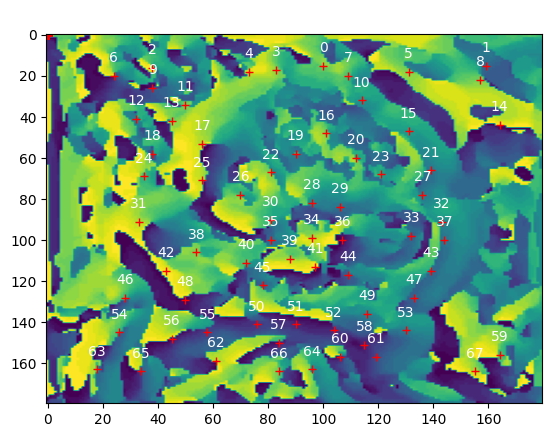

torch.Size([10, 180, 180]) torch.Size([10, 3, 94]) torch.Size([10, 94, 2])


In [6]:
batch_result,orien1 = predict_single_points(model,batch)

In [7]:
print('QTD batch ',len(batch_result))
for i,b in enumerate(batch_result):
    print('batch ',i,' QTD features ', len(b))

QTD batch  10
batch  0  QTD features  68
batch  1  QTD features  77
batch  2  QTD features  94
batch  3  QTD features  86
batch  4  QTD features  77
batch  5  QTD features  87
batch  6  QTD features  75
batch  7  QTD features  53
batch  8  QTD features  88
batch  9  QTD features  45


In [8]:
img_batch.shape

torch.Size([10, 3, 180, 180])

In [9]:
_kp1, _orie1 = model(img_batch.to(device))

batch  0  QTD features  68


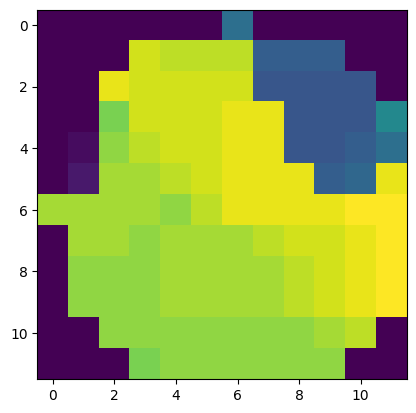

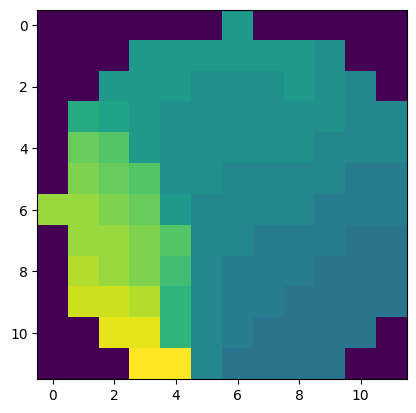

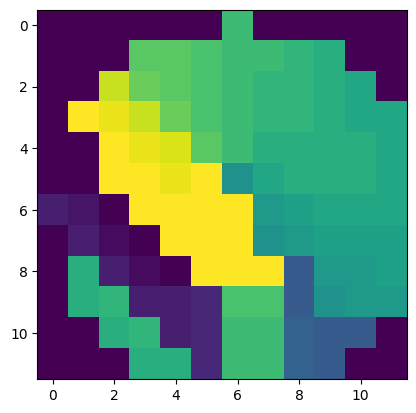

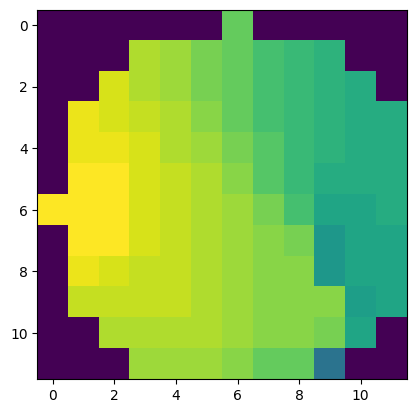

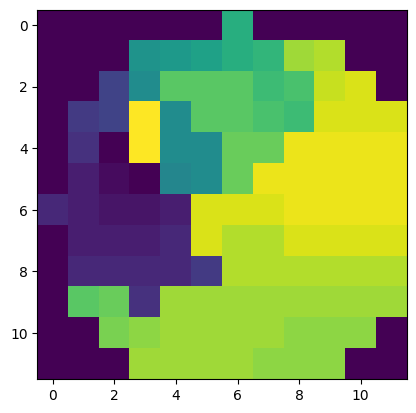

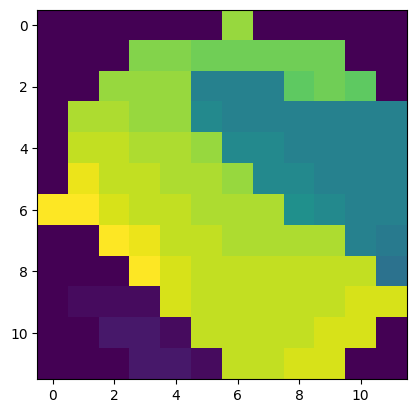

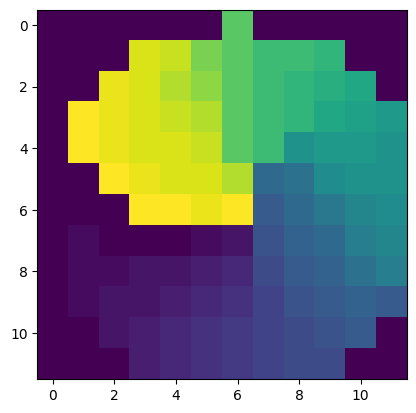

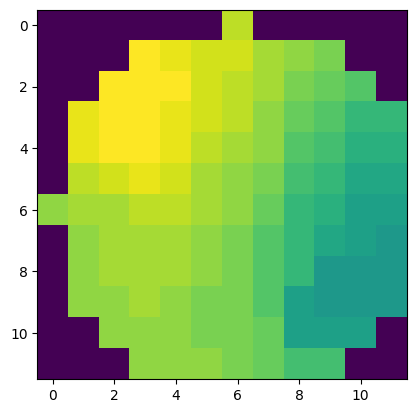

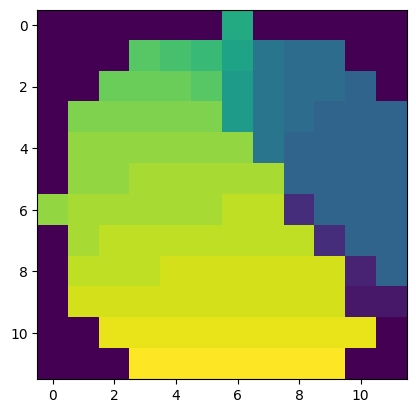

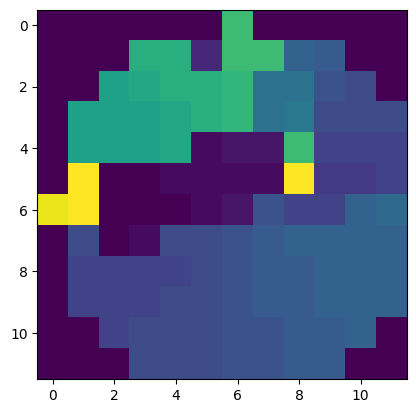

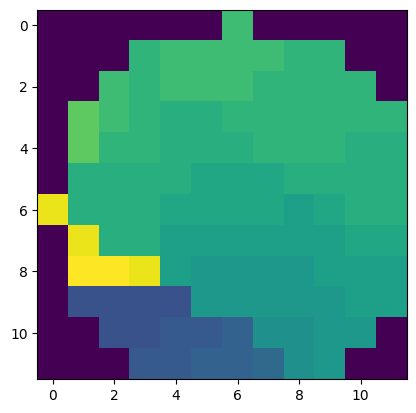

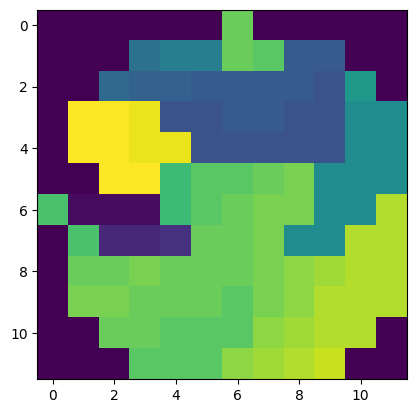

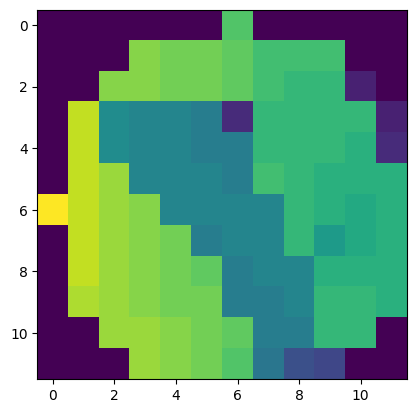

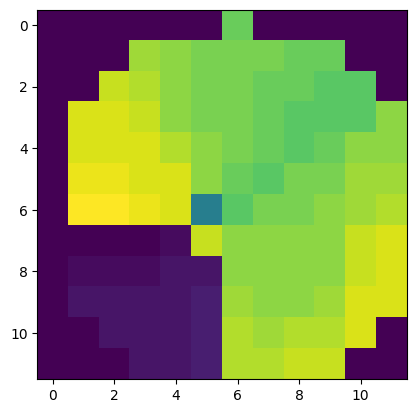

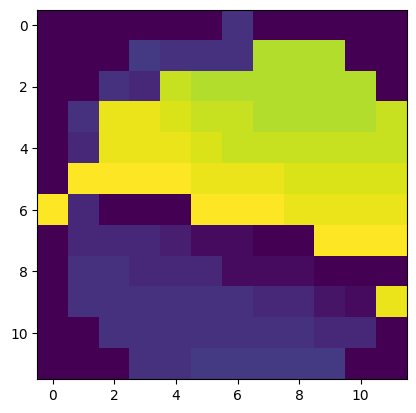

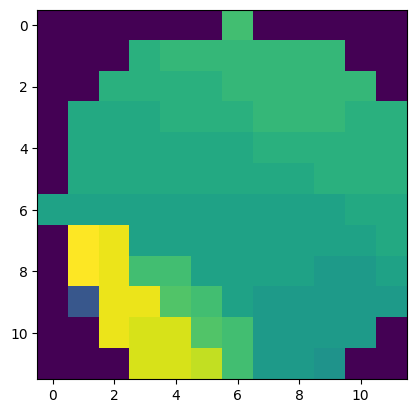

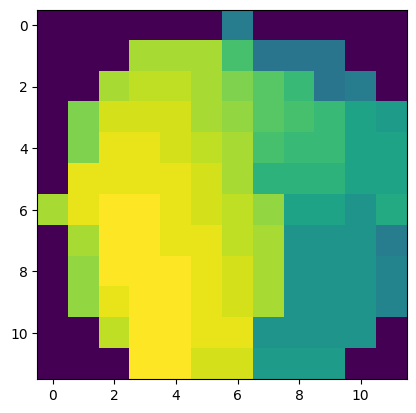

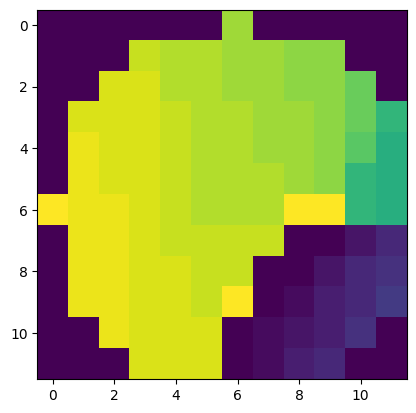

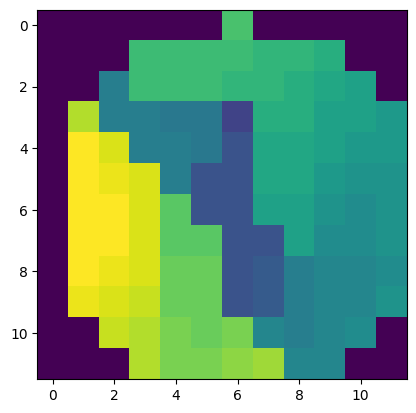

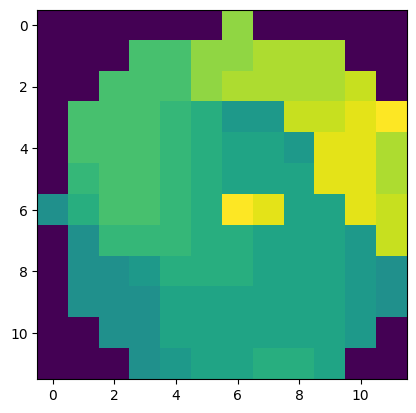

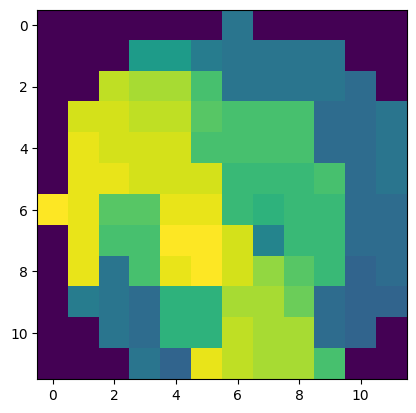

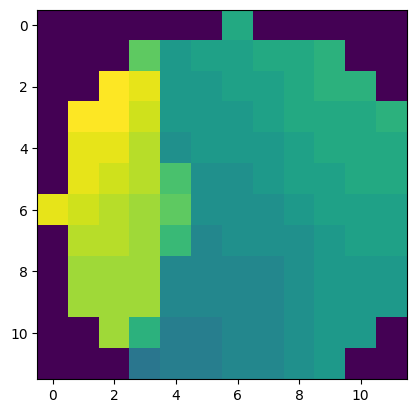

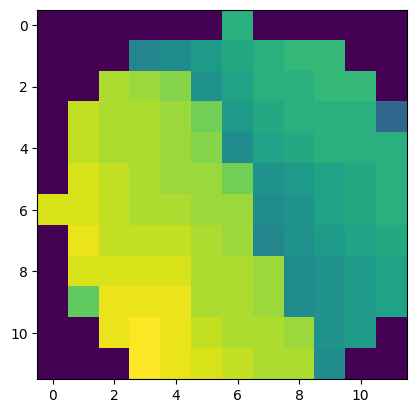

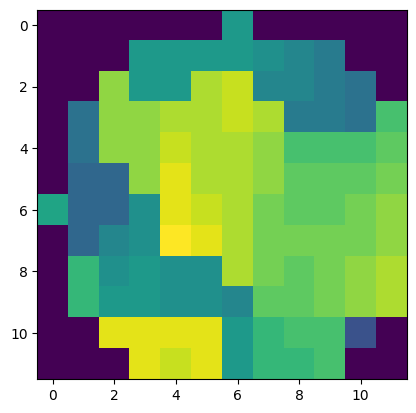

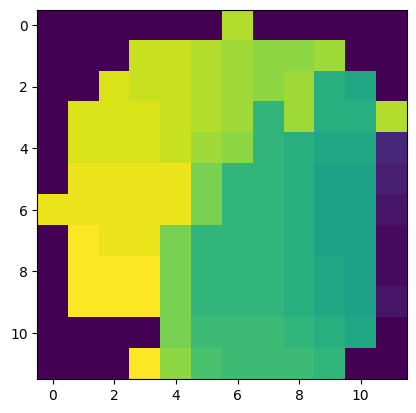

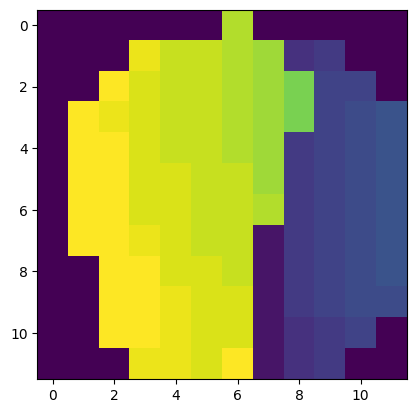

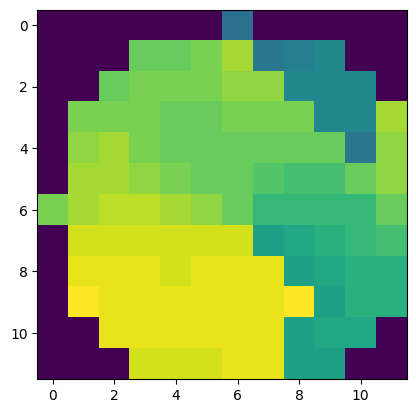

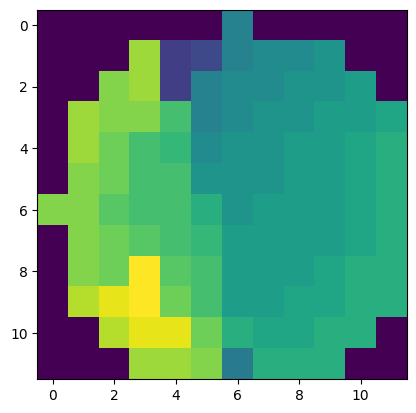

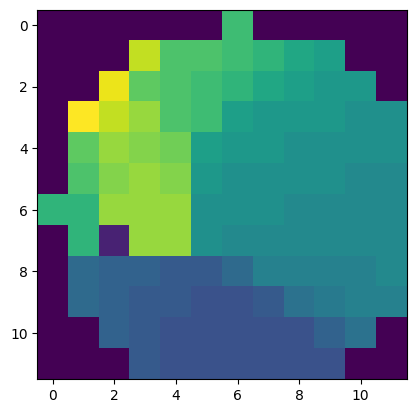

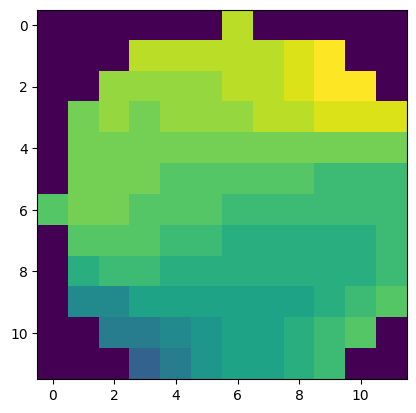

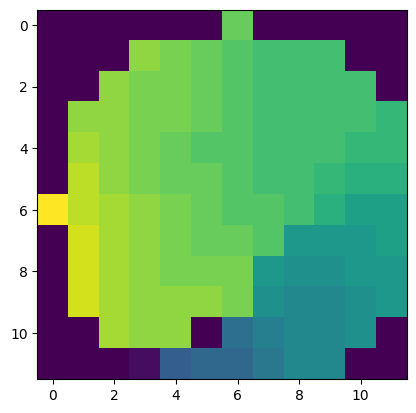

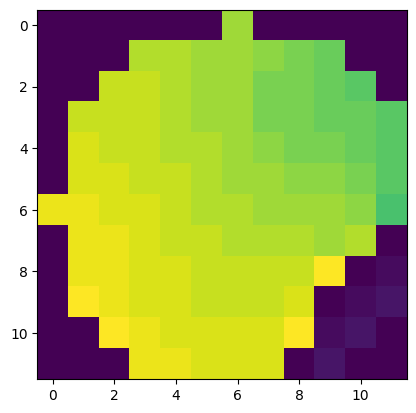

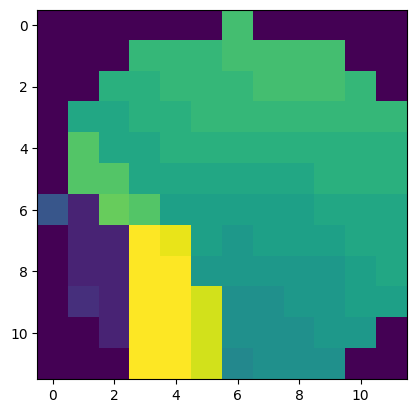

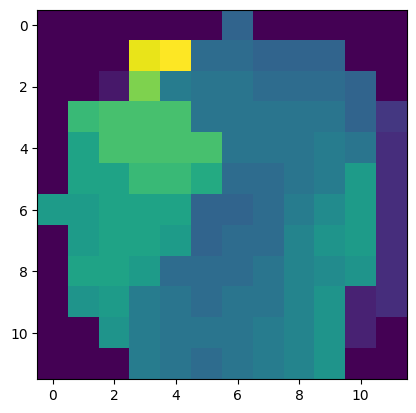

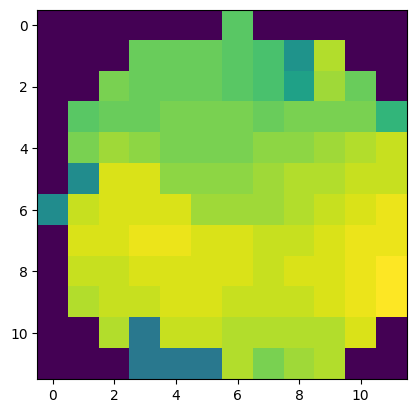

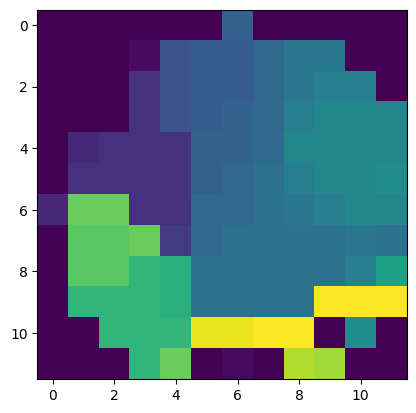

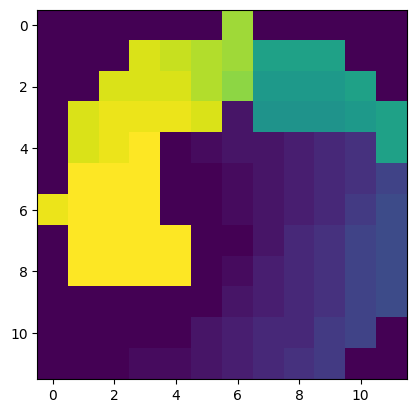

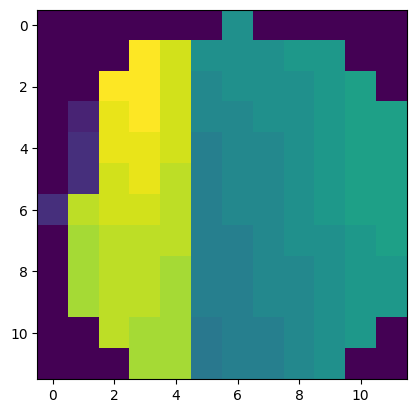

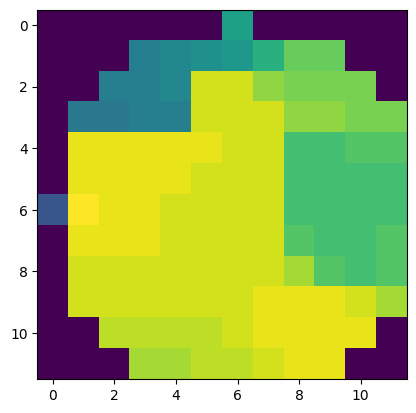

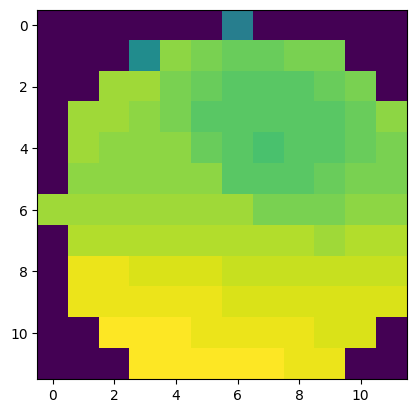

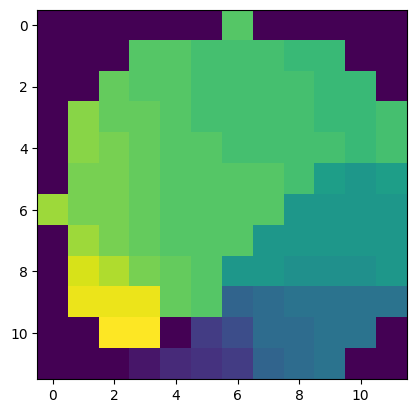

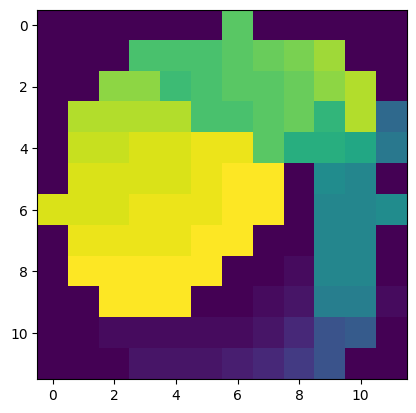

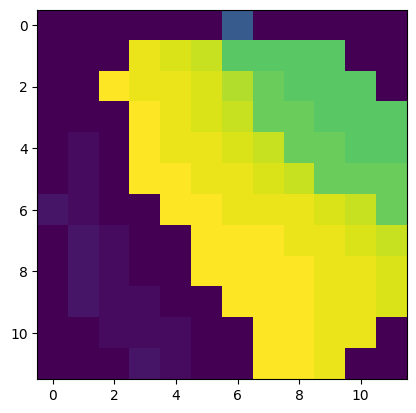

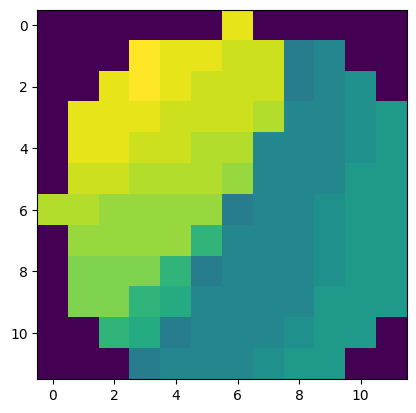

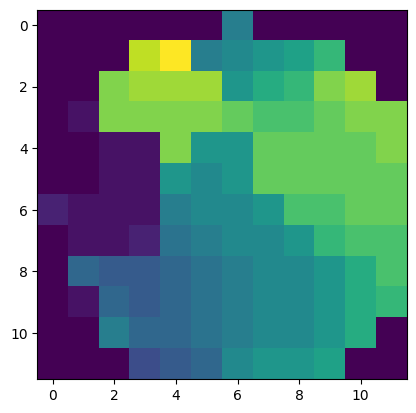

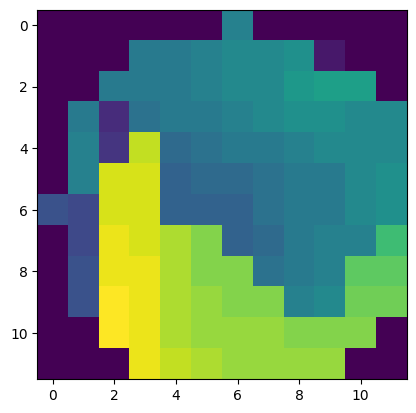

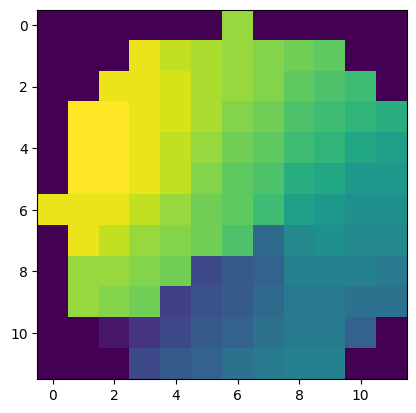

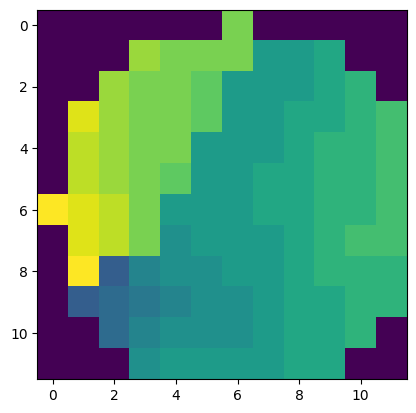

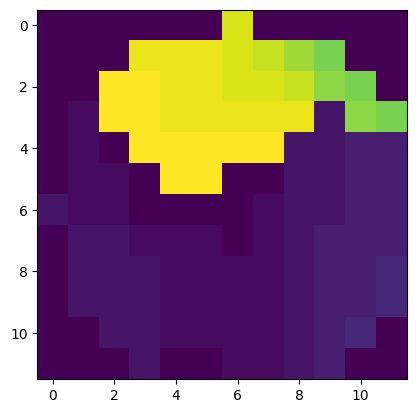

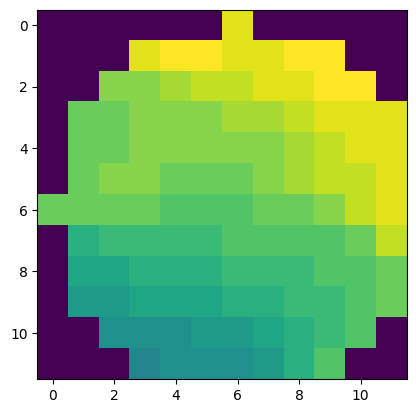

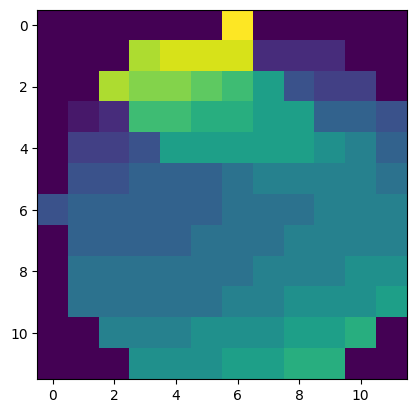

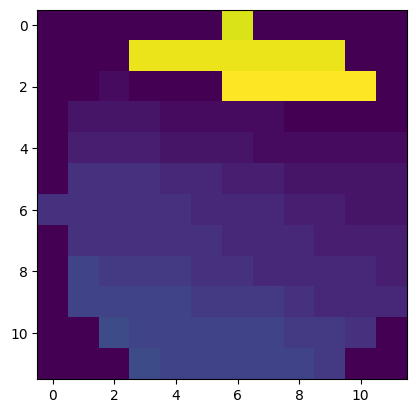

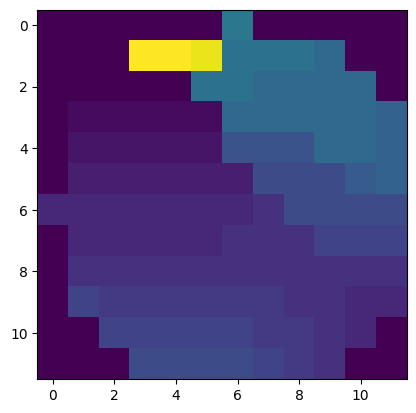

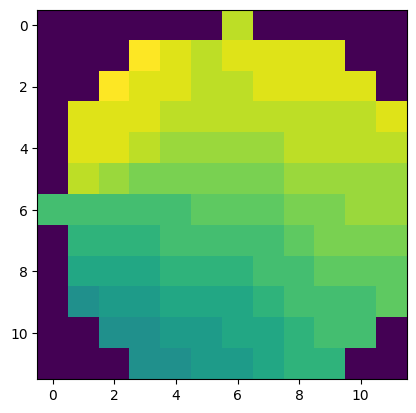

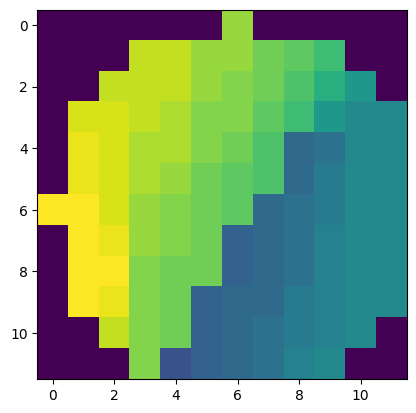

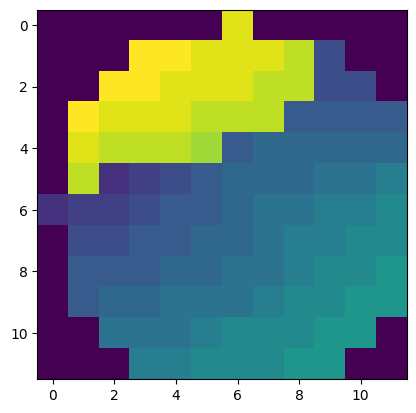

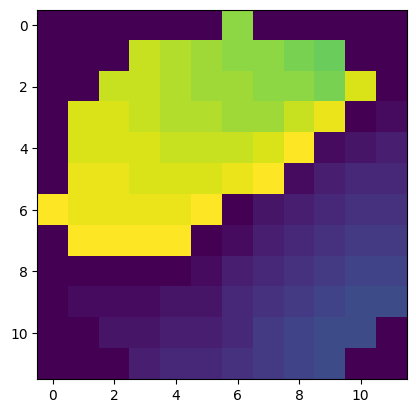

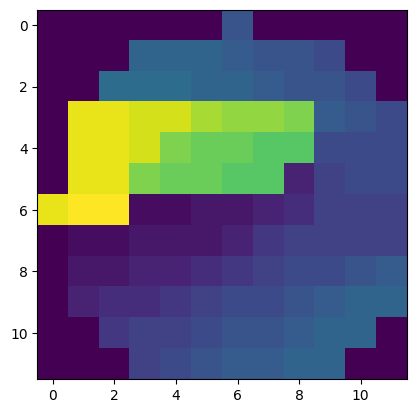

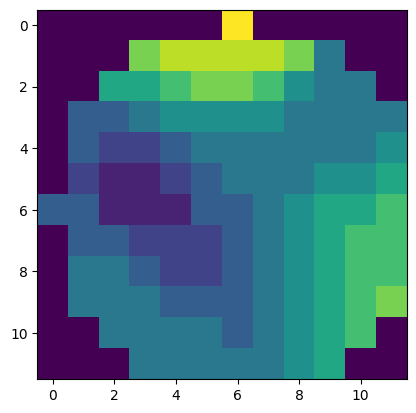

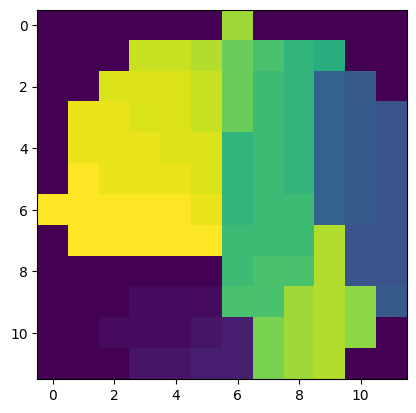

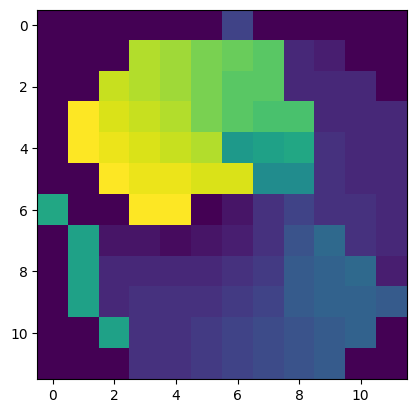

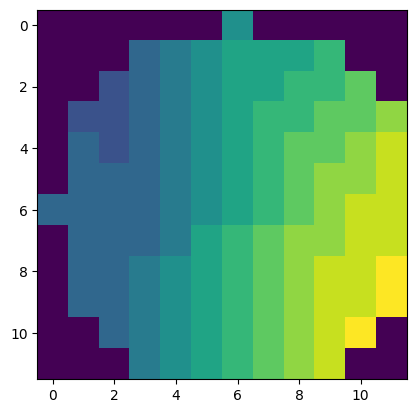

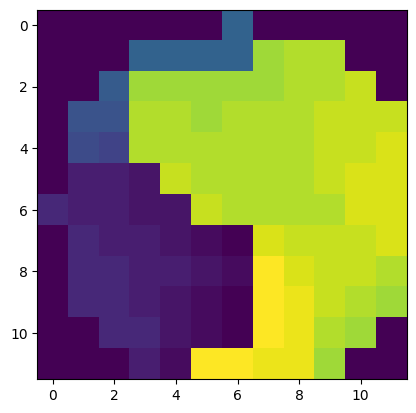

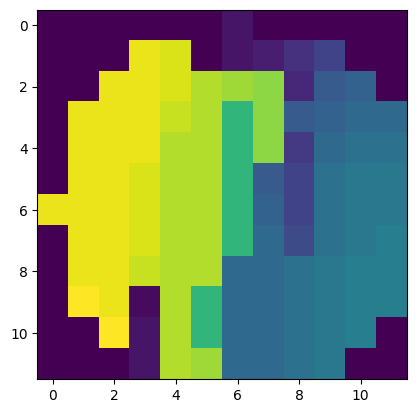

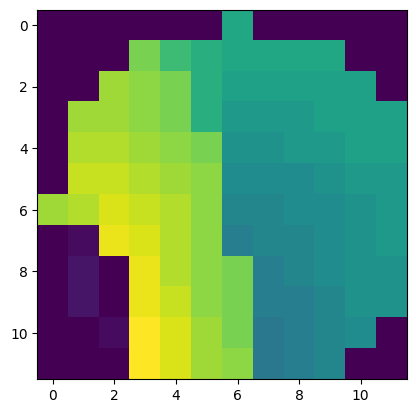

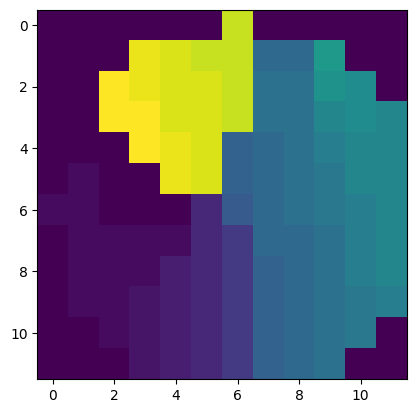

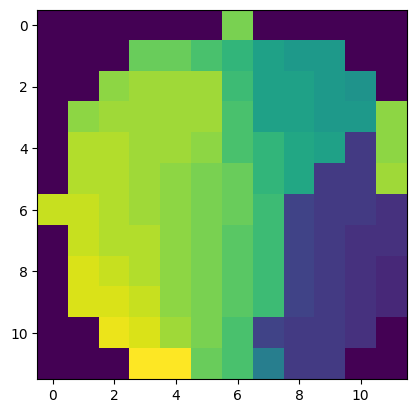

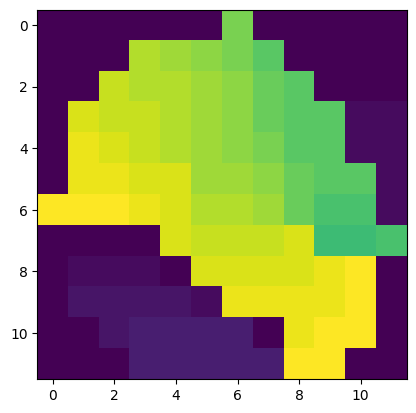

In [10]:
for i,detect in enumerate(batch_result):
    print('batch ',i,' QTD features ', len(detect))
    for j,(box,img) in enumerate(detect):
        plt.imshow(img)
        plt.show()
    break

In [11]:
from e2cnn import gspaces, nn
r2_act = gspaces.Rot2dOnR2(N=args.group_size)
feat_type_ori_est = nn.FieldType(r2_act, [r2_act.regular_repr])
pool_max = nn.PointwiseMaxPoolAntialiased(feat_type_ori_est,kernel_size=2)

In [12]:
feat_type_ori_est

[36-Rotations: {regular}]

In [13]:
img_temp = batch_result[0][0][1]
_orie1.shape

torch.Size([10, 36, 180, 180])

torch.Size([10, 36, 180, 180])
torch.Size([36, 25, 20])


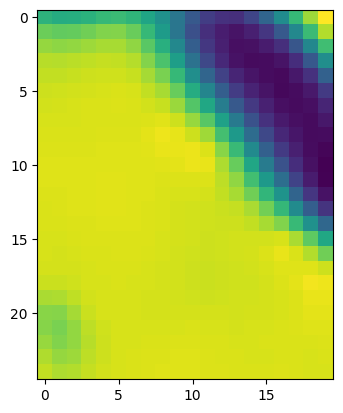

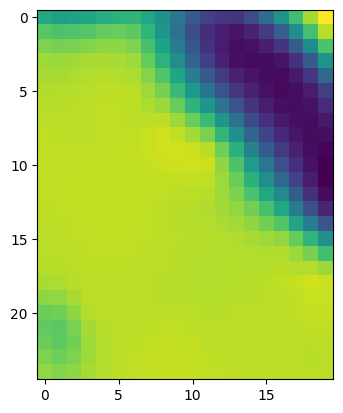

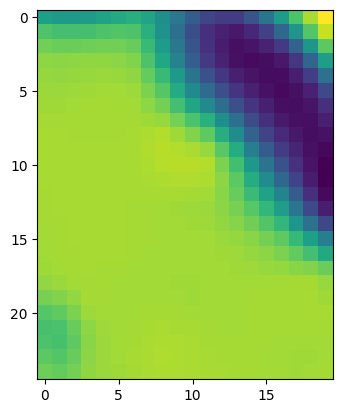

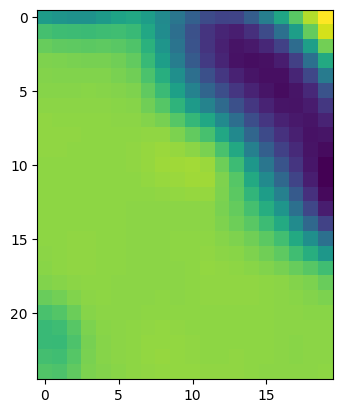

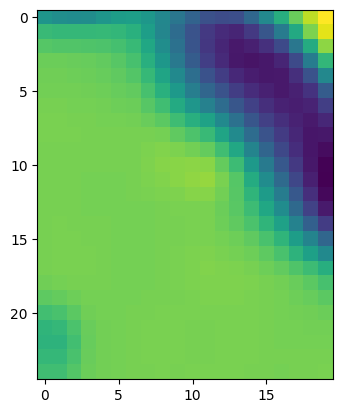

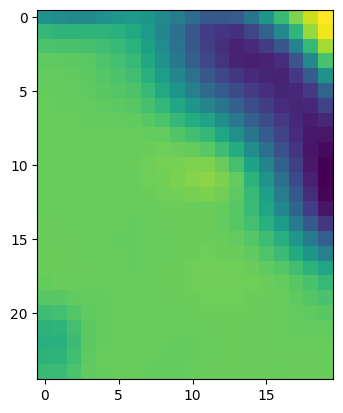

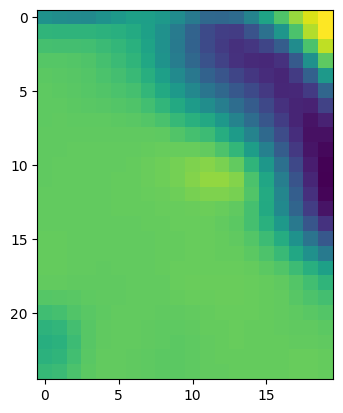

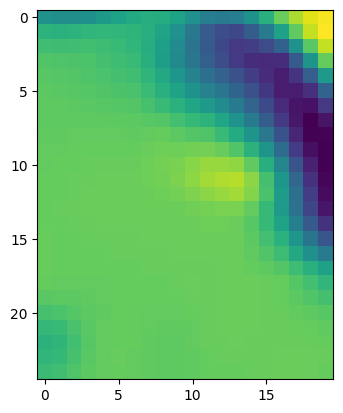

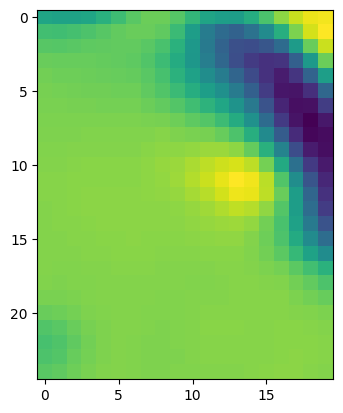

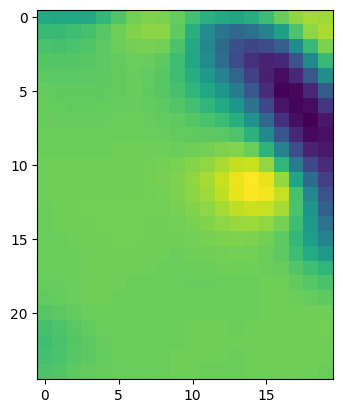

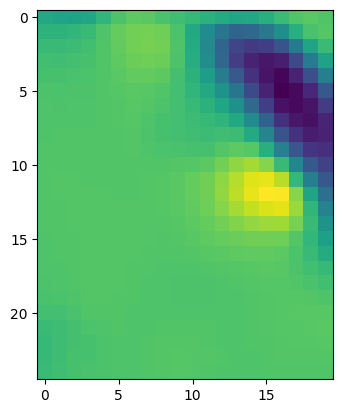

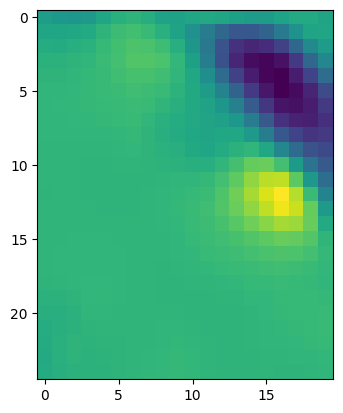

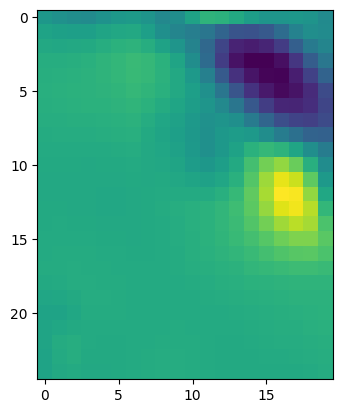

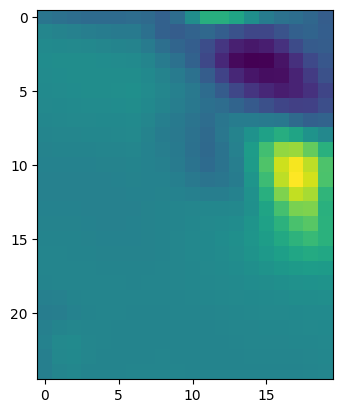

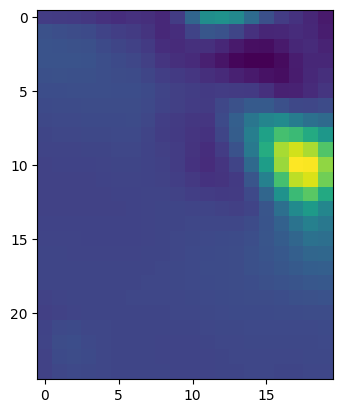

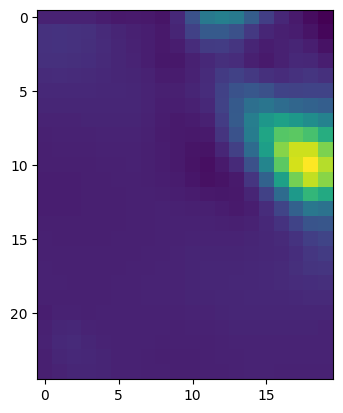

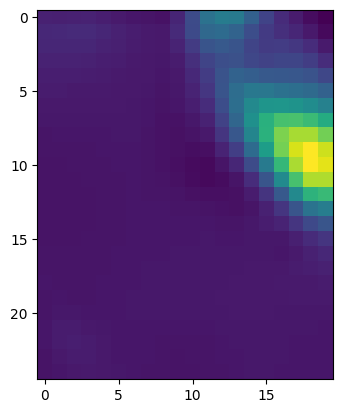

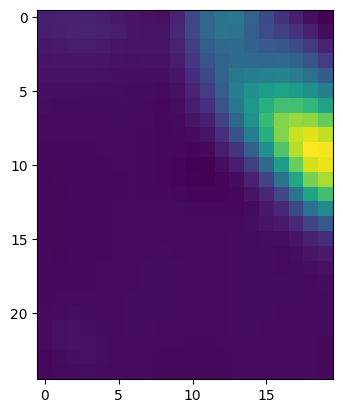

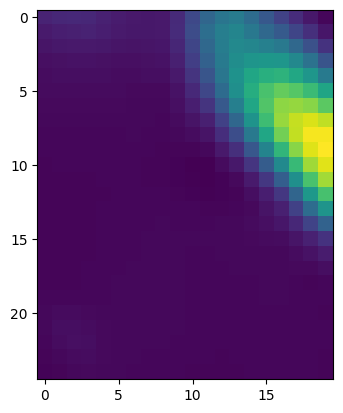

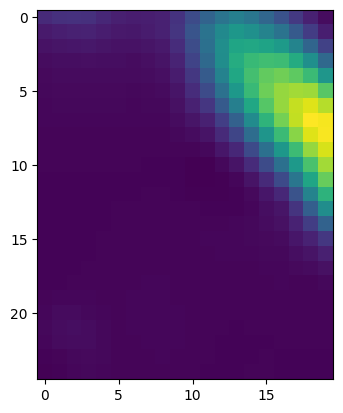

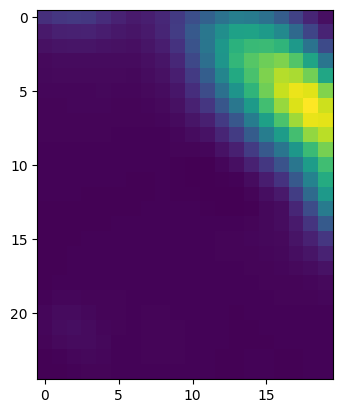

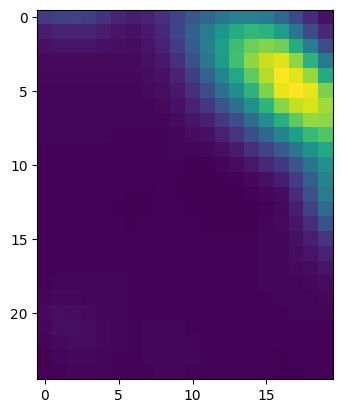

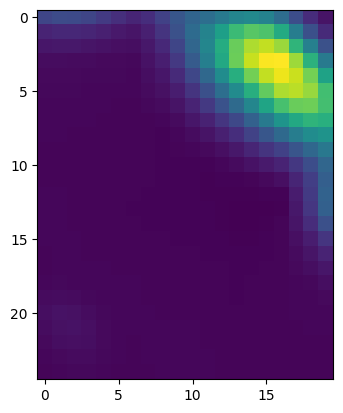

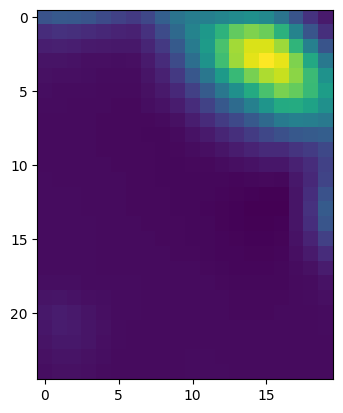

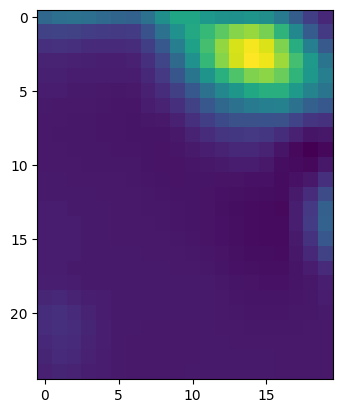

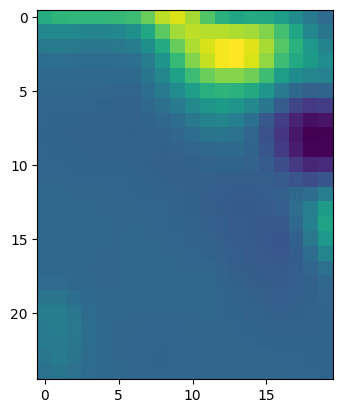

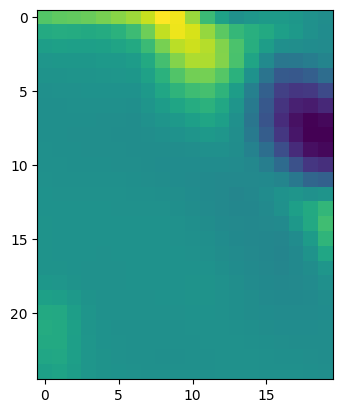

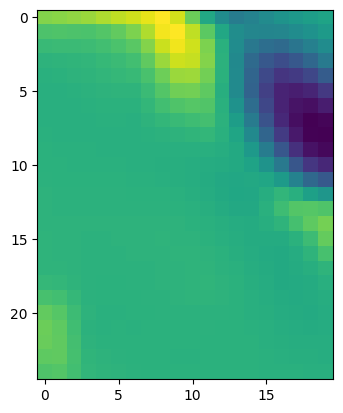

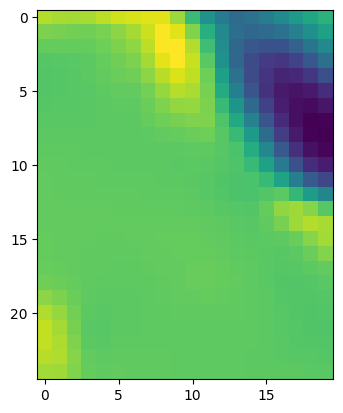

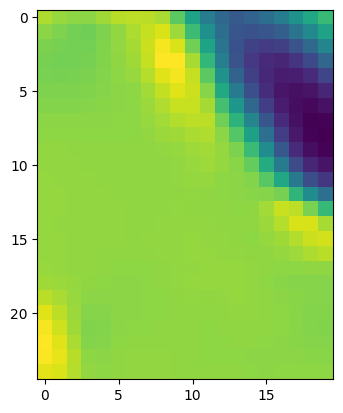

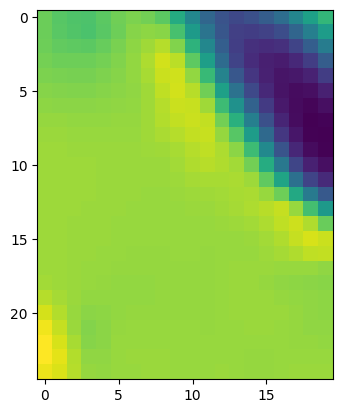

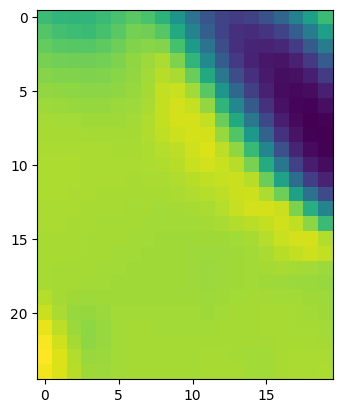

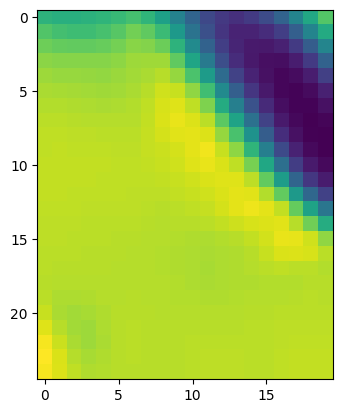

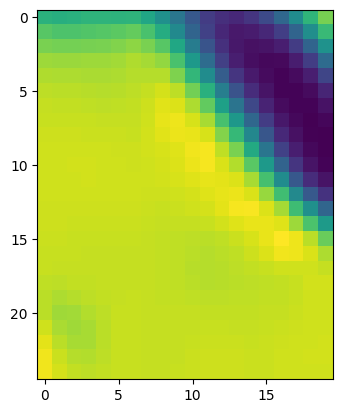

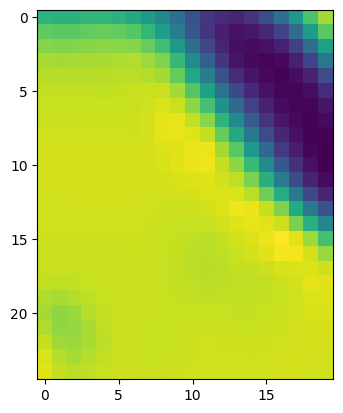

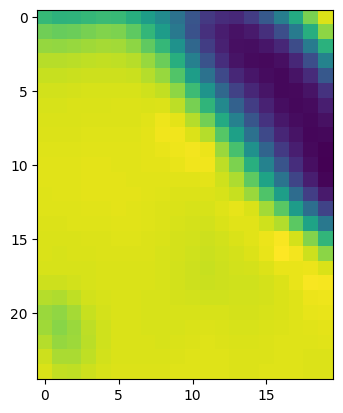

In [14]:
g_size = _orie1.shape[1]
print(_orie1.shape)
filtro = _orie1[0,:,25:50,100:120]
print(filtro.shape)
for i in range(g_size):
    plt.imshow(filtro[i].cpu().detach())
    plt.show()